In [58]:
from ragraph.io.esl import from_esl
graph = from_esl(["./esl"])

import raesl.plot
figure = raesl.plot.mdm(
    graph,
    node_kinds=["component"],
)
figure.show()

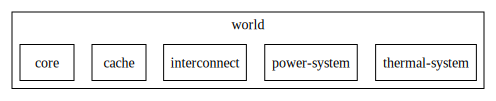

In [59]:
digraph = raesl.plot.functional_dependency_diagram(
    graph,
    root=graph["world"],
    levels=2,
)
digraph

In [ ]:
from ragraph.plot.generic import Style as RaGraphStyle

style = raesl.plot.Style(
    ragraph=RaGraphStyle(
        piemap=dict(
            display="labels",
            mode="relative",
            highlight_row_annotation="row",
            highlight_row_color="rgba(255,0,0,0.5)",
        ),
    )
)

parents = {
    "world.core": "rgba(255,0,0,0.3)",
    "world.cache": "rgba(0,255,0,0.3)",
    "world.interconnect": "rgba(0,0,255,0.3)",
    "world.power": "rgba(255,255,0,0.3)",
    "world.thermal": "rgba(0,255,255,0.3)",
};

for node in graph.nodes:
    for parent, color in parents.items():
        if node.name.startswith(parent):
            break

    if node.name.startswith(parent):
        node.annotations.row = color

figure = raesl.plot.mdm(
    graph,
    # node_kinds=["component", "variable", "function_spec", "design_spec", "relation_spec"],
    # edge_kinds=["functional_dependency", "mapping_dependency"],
    depth=4,
    style=style,
)

figure.show()


In [61]:
from ragraph.analysis import sequence
from raesl.plot.view_funcs import multi_domain
import ragraph.plot

# Select correct nodes and edges to be displayed.
nodes, edges = multi_domain(
    graph,
    depth=4
)

leaf_comps = [n for n in nodes if n.kind == "component"]
leaf_funcs = [n for n in nodes if n.kind == "function_spec"]
leaf_design = [n for n in nodes if n.kind == "design_spec"]
leaf_models = [n for n in nodes if n.kind == "relation_spec"]
leaf_vars = [n for n in nodes if n.kind == "variable"]

# Sequence functions.
_, _, sequenced_functions = sequence.utils.branchsort(algo=sequence.scc_tearing, graph=graph, algo_args=dict(inf=1, dep=1, mu=3), inplace=True, nodes=leaf_models + leaf_vars)

# Reload figure based on sequence.
figure = ragraph.plot.mdm(
    leafs = leaf_comps + sequenced_functions,
    edges = edges,
    style= ragraph.plot.Style(
        piemap=dict(
            display="labels",
            mode="relative",
            fields=graph.edge_labels
        ),
    )
)

figure

from ragraph.analysis import heuristics

leafs = [node.name for node in graph.nodes if node.kind == "relation_spec" and node.is_leaf]

# Cluster components
heuristics.markov_gamma(
    graph=graph,
    alpha=1,     # Expension parameter.
    beta=4,    # Inflation parameter.
    mu=8,      # Evaporation parameter.
    gamma=8,   # Bus detection parameter.
    leafs = [node.name for node in graph.nodes if node.kind == "variable" and node.is_leaf],
    inplace=True
)

# Reloaded MDM based on clustered graph.
figure = raesl.plot.mdm(
    graph,
    # node_kinds=["component", "variable", "function_spec", "design_spec"],
    # edge_kinds=["functional_dependency", "mapping_dependency"],
    depth=10,
)

figure